In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, ttest_ind
from sklearn.metrics import f1_score
from f01_preprocess_datasets import datasets
from f03_encoded_classification import models

In [2]:
results_folder = 'results_encoded_classification'

In [3]:
def get_file_paths(folder):
    fileNames = os.listdir(folder)
    paths = []
    for fileName in fileNames:
        paths.append(f'{folder}/{fileName}')
    return paths

def aggregate_binary_results():
    for dataset in datasets:
        for model in ['binaryANN', 'binaryET']:
            path = f'./{results_folder}/{dataset}/{model}'
            file_paths = get_file_paths(path)
            # Concatenate Files
            results = []
            for file_path in file_paths:
                if 'summary.csv' not in file_path:
                    result = pd.read_csv(file_path)
                    results.append(result)
            results = pd.concat(results, ignore_index=True)
            results.to_csv(f'{path}/summary.csv', index=False)


def calculate_weighted_metrics(result):
    metrics = ['Accuracy', 'F1', 'Enc Accuracy', 'Enc F1']
    categories = result['Category']
    proportions = result['Proportion']
    metrics_results = result.drop(['Category', 'Proportion'], axis=1)
    w_mean = np.matmul(metrics_results.transpose(), proportions)
    summary = pd.DataFrame(np.array(w_mean).reshape((1,4)))
    summary.columns = metrics
    return summary

def aggregate_multiclass_results():
    for dataset in datasets:
        for model in ['multiANN', 'multiET']:
            path = f'./{results_folder}/{dataset}/{model}'
            file_paths = get_file_paths(path)
            # Concatenate Files
            results = []
            for file_path in file_paths:
                if 'summary.csv' not in file_path:
                    result = pd.read_csv(file_path)
                    w_averages = calculate_weighted_metrics(result)
                    results.append(w_averages)
                
            results = pd.concat(results, ignore_index=True)
            results.to_csv(f'{path}/summary.csv', index=False)

In [4]:
aggregate_binary_results()

In [5]:
pd.read_csv(f'./{results_folder}/{datasets[4]}/binaryANN/summary.csv')

,Accuracy,F1,Enc Accuracy,Enc F1
0,0.977477,0.976411,0.958287,0.955843
1,0.969902,0.968767,0.952698,0.950589
2,0.975524,0.974370,0.952900,0.949442
3,0.974043,0.972686,0.952463,0.950233
4,0.968993,0.967284,0.954011,0.951772
5,0.974649,0.973423,0.949635,0.946583
6,0.979026,0.978246,0.950746,0.947886
7,0.972158,0.970627,0.953203,0.950268
8,0.978285,0.977372,0.956099,0.954007
9,0.967714,0.965946,0.951453,0.948720


In [6]:
aggregate_multiclass_results()

In [7]:
pd.read_csv(f'./{results_folder}/{datasets[4]}/multiANN/summary.csv')

,Accuracy,F1,Enc Accuracy,Enc F1
0,0.969906,0.972730,0.951251,0.956402
1,0.970105,0.972393,0.953101,0.959129
2,0.964894,0.969027,0.949345,0.955156
3,0.971896,0.974683,0.954128,0.959768
4,0.969029,0.971754,0.948483,0.955324
5,0.963755,0.968488,0.942975,0.953035
6,0.968921,0.971989,0.957784,0.961822
7,0.971233,0.974615,0.953030,0.957243
8,0.969333,0.972259,0.950964,0.955459
9,0.970310,0.973269,0.954412,0.958859


# Wilcoxon Test

## Q-Value

In [8]:
def quatile_wilcoxon(x, y):
    for diff in np.arange(0, 0.03, 0.0005):
        pvalue = wilcoxon(x, y+diff, alternative='less').pvalue
        if(pvalue<0.05):
            # print(f'Difference: {diff} - P-Value: {pvalue}')
            return diff

In [9]:
def summarize_dataset_results(dataset):
    results = []
    for model in models:
        dataset_path = f'./{results_folder}/{dataset}'
        data = pd.read_csv(f'{dataset_path}/{model}/summary.csv')
        means = np.array(np.mean(data, axis=0))
    
        diff = 0.025
        acc = data['Accuracy']
        enc_acc = data['Enc Accuracy']
        diff_acc = np.mean(acc - enc_acc)
        # pvalue = wilcoxon(acc - (enc_acc+diff), alternative='less').pvalue
        qvalue = quatile_wilcoxon(acc, enc_acc)
        
        result = np.concatenate(([model], means, [diff_acc], [qvalue]))
        results.append(result)
    summary = pd.DataFrame(results)
    summary.columns = ['Model', 'Mean Accuracy', 'Mean F1', 'Mean Enc Accuracy', 'Mean Enc F1', 'Accuracy Difference', 'Q-Value Accuracy']
    summary.to_csv(f'{dataset_path}/summary.csv', index=False)

In [10]:
for dataset in datasets:
    summarize_dataset_results(dataset)

In [11]:
pd.read_csv(f'./{results_folder}/{datasets[4]}/summary.csv')

,Model,Mean Accuracy,Mean F1,Mean Enc Accuracy,Mean Enc F1,Accuracy Difference,Q-Value Accuracy
0,binaryANN,0.973777,0.972513,0.953150,0.950534,0.020628,0.0235
1,binaryET,0.994361,0.994133,0.991846,0.991510,0.002515,0.0030
2,multiANN,0.968938,0.972121,0.951547,0.957220,0.017391,0.0195
3,multiET,0.970076,0.973208,0.950515,0.956432,0.019561,0.0220


# Latex table

In [12]:
datasets_latex = ['CIC-IDS-2017', 'UNSW-NB15', 'NF-UNSW-NB15-v2', 'CSE-CIC-IDS2018', 'NSL-KDD']
models_latex = ['Binary ANN', 'Binary ET', 'Multiclass ANN', 'Multiclass ET']

In [13]:
for i in range(5):
    summary = pd.read_csv(f'./{results_folder}/{datasets[i]}/summary.csv')
    dataset = datasets_latex[i]
    first_row = '\t\multirow{4}{*}{\\textbf{' + dataset + '}}' 
    print(first_row)
    for j in range(4):
        model = models_latex[j]
        acc = "%.3f" % round(summary.loc[j, 'Mean Accuracy'], 3)
        enc_acc = "%.3f" % round(summary.loc[j, 'Mean Enc Accuracy'], 3)
        # diff_acc ="%.3f" % round(summary.loc[j, 'Accuracy Difference'], 3)
        if model not in ['Multiclass ANN', 'Multiclass ET']:
            f1 = "%.3f" % round(summary.loc[j, 'Mean F1'], 3)
            enc_f1 = "%.3f" % round(summary.loc[j, 'Mean Enc F1'], 3)
        else:
            f1 = '-'
            enc_f1 = '-'
        
        row = '\t\t& \\textit{'+ model + '} & ' + acc + ' & ' + enc_acc + ' & ' + f1 + ' & ' + enc_f1 + '\\\\'
        if j == 3:
            row = '\t\t& \\textit{'+ model + '} & ' + acc + ' & ' + enc_acc + ' & ' + f1 + ' & ' + enc_f1 + '\\\\ \\hline'
        print(row)

	\multirow{4}{*}{\textbf{CIC-IDS-2017}}
		& \textit{Binary ANN} & 0.978 & 0.963 & 0.952 & 0.916\\
		& \textit{Binary ET} & 0.999 & 0.998 & 0.997 & 0.995\\
		& \textit{Multiclass ANN} & 0.982 & 0.969 & - & -\\
		& \textit{Multiclass ET} & 0.982 & 0.968 & - & -\\ \hline
	\multirow{4}{*}{\textbf{UNSW-NB15}}
		& \textit{Binary ANN} & 0.996 & 0.996 & 0.930 & 0.921\\
		& \textit{Binary ET} & 1.000 & 1.000 & 0.996 & 0.990\\
		& \textit{Multiclass ANN} & 0.990 & 0.988 & - & -\\
		& \textit{Multiclass ET} & 0.990 & 0.988 & - & -\\ \hline
	\multirow{4}{*}{\textbf{NF-UNSW-NB15-v2}}
		& \textit{Binary ANN} & 0.996 & 0.995 & 0.947 & 0.941\\
		& \textit{Binary ET} & 0.998 & 0.997 & 0.970 & 0.969\\
		& \textit{Multiclass ANN} & 0.983 & 0.979 & - & -\\
		& \textit{Multiclass ET} & 0.983 & 0.979 & - & -\\ \hline
	\multirow{4}{*}{\textbf{CSE-CIC-IDS2018}}
		& \textit{Binary ANN} & 0.997 & 0.997 & 0.994 & 0.994\\
		& \textit{Binary ET} & 0.999 & 1.000 & 0.999 & 0.999\\
		& \textit{Multiclass ANN} & 0.998

# Represetaciones visuales de resultados

In [14]:
q_values = []
for dataset in datasets:
    summary = pd.read_csv(f'./{results_folder}/{dataset}/summary.csv')
    q_value = summary['Q-Value Accuracy']
    q_values.append(q_value) 
q_values = np.array(q_values)

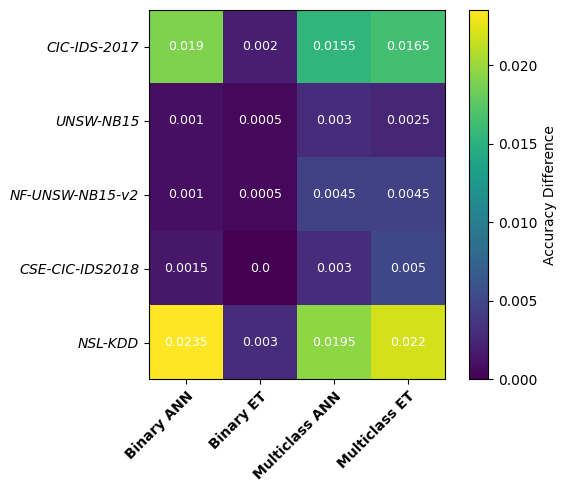

In [15]:
fig, ax = plt.subplots()
im = ax.imshow(q_values)
# Color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Accuracy Difference', rotation=90)
# Axis Labels
ax.set_xticks(np.arange(len(models_latex)), labels=models_latex, fontweight='bold')
ax.set_yticks(np.arange(len(datasets_latex)), labels=datasets_latex, fontstyle='italic')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
# Matrix q-values
for i in range(len(datasets)):
    for j in range(len(models)):
        q_value = np.round(q_values[i, j], 4)
        text = ax.text(j, i, q_value, ha="center", va="center", color="w", size=9)
plt.savefig(f'./{results_folder}/q_value_summary.png', bbox_inches='tight', dpi=400)